In [11]:
import polars as pl
import datetime
import re
import pandas as pd

def add_parsed_dates_polars(df: pl.DataFrame, ref_date_col: str = "ref_date") -> pl.DataFrame:
    ref_date = df[ref_date_col].to_list()[0]
    ref_date_dt = datetime.datetime.strptime(ref_date, "%Y-%m-%d")
    result = (
        df.lazy()
        .with_columns([
            pl.col("var_name").str.extract(r"^(\w+)D\d+H\d+$", 1).alias("variable_name"),
            pl.col("var_name").str.extract(r"D(\d+)H(\d+)$", 1).cast(pl.Int32).alias("days"),
            pl.col("var_name").str.extract(r"D(\d+)H(\d+)$", 2).cast(pl.Int32).alias("hours"),
        ])
        .with_columns([
            (pl.lit(ref_date_dt)
             - pl.duration(days=pl.col("days"))
             + pl.duration(hours=pl.col("hours"))
            ).alias("result_date")
        ])
        .drop(["var_name", ref_date_col, "days", "hours"])
        .select(
            ["result_date"] +
            [col for col in df.columns if col not in ["result_date", "variable_name", "var_name", ref_date_col, "days", "hours"]]
        )
        .collect()
    )
    return result


2025-08-17 21:54:24,215 - INFO - NumExpr defaulting to 12 threads.


In [2]:
import re
import datetime

def parse_varname_dates_polars(ref_var, ref_date):
    rd = datetime.datetime.strptime(ref_date, "%Y-%m-%d")
    match = re.search(r'(\w+)D(\d+)H(\d+)', ref_var)
    if match:        
        name = match.group(1)
        days = int(match.group(2))
        hours = int(match.group(3))
        result_date = rd - datetime.timedelta(days=days) + datetime.timedelta(hours=hours)
        return name, result_date
    else:
        raise ValueError("varname format not recognized")

In [3]:
import polars as pl
import logging
from pathlib import Path
from functools import reduce

# Configure the logging system
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def load_station_data(
    stationid: str,
    location_data: str,
    filenames: list[str] = None,
    join_key: str = "result_date"
) -> pl.DataFrame:
    """
    Loads, cleans, and lazily joins multiple weather station CSV datasets for a given station ID.

    Parameters
    ----------
    stationid : str
        Weather station identifier used to construct default filenames.
    location_data : str
        Directory path where CSV files are located.
    filenames : list of str, optional
        List of filenames to load. If None, defaults to airtemp, precip, and relhum datasets.
    join_key : str, optional
        Column name to join datasets on. Defaults to 'result_date'.

    Returns
    -------
    pl.DataFrame
        Final merged dataset, sorted in descending order by join_key.
    """

    if filenames is None:
        filenames = [
            f"{stationid}_model_data_airtemp.csv",
            f"{stationid}_model_data_precip.csv",
            f"{stationid}_model_data_relhum.csv"
        ]

    logging.info(f"[load_station_data] Loading data for station '{stationid}' from {len(filenames)} files.")
    filepaths = [Path(location_data) / fname for fname in filenames]

    def read_and_clean_lazy(filepath: Path) -> pl.LazyFrame:
        """
        Reads and cleans a single dataset as a LazyFrame.

        Assumes that the input CSV contains a 'ref_date' column which is parsed
        into a proper date format and renamed (or augmented) as `join_key`.

        Parameters
        ----------
        filepath : Path
            Path to the CSV file.

        Returns
        -------
        pl.LazyFrame
            Cleaned LazyFrame with a parsed date column.
        """
        logging.info(f"[load_station_data] Reading and cleaning file: {filepath.name}")
        df = pl.read_csv(filepath)
        df_clean = add_parsed_dates_polars(df, ref_date_col="ref_date")  # User-defined function
        logging.info(f"[load_station_data] Completed. Final shape: {df_clean.shape}")
        return df_clean.lazy()

    # Step 1: Load and preprocess all datasets as LazyFrames
    lazy_dfs = [read_and_clean_lazy(fp) for fp in filepaths]

    # Step 2: Create base join key frame (all unique result_date values)
    logging.info(f"[load_station_data] Creating base date frame from all datasets using key '{join_key}'")
    base_dates = (
        pl.concat([df.select([join_key]) for df in lazy_dfs])
        .unique()
        .sort(join_key)
        .cache()  # Cache the base frame for reuse in joins
    )

    # Step 3: Reduce - Join all datasets onto the base_dates frame
    def join_datasets(left: pl.LazyFrame, right: pl.LazyFrame) -> pl.LazyFrame:
        cols_to_add = [col for col in right.collect_schema() if col != join_key]
        selected_cols = [join_key] + cols_to_add
        logging.info(f"[load_station_data] Joining with columns: {cols_to_add}")
        return left.join(right.select(selected_cols), on=join_key, how="left")

    merged = reduce(join_datasets, lazy_dfs, base_dates)

    # Step 4: Final sort and collect
    logging.info(f"[load_station_data] All datasets joined. Collecting final result...")
    final_df = merged.sort(join_key, descending=True).collect()
    logging.info(f"[load_station_data] Completed. Final shape: {final_df.shape}")

    return final_df

In [4]:
stationid = "72614594705"
location_data = "../data/weathermetrics/"
df_merged = load_station_data(stationid, location_data)
# df_merged.head(10)

2025-08-17 21:52:01,784 - INFO - [load_station_data] Loading data for station '72614594705' from 3 files.
2025-08-17 21:52:01,785 - INFO - [load_station_data] Reading and cleaning file: 72614594705_model_data_airtemp.csv
2025-08-17 21:52:01,961 - INFO - [load_station_data] Completed. Final shape: (271226, 2)
2025-08-17 21:52:01,962 - INFO - [load_station_data] Reading and cleaning file: 72614594705_model_data_precip.csv
2025-08-17 21:52:02,020 - INFO - [load_station_data] Completed. Final shape: (249816, 2)
2025-08-17 21:52:02,021 - INFO - [load_station_data] Reading and cleaning file: 72614594705_model_data_relhum.csv
2025-08-17 21:52:02,045 - INFO - [load_station_data] Completed. Final shape: (6664, 4)
2025-08-17 21:52:02,047 - INFO - [load_station_data] Creating base date frame from all datasets using key 'result_date'
2025-08-17 21:52:02,050 - INFO - [load_station_data] Joining with columns: ['air_temp_degrees_cels']
2025-08-17 21:52:02,053 - INFO - [load_station_data] Joining with

In [5]:
from typing import Callable, Union
def aggregate_time(
    df: pl.DataFrame,
    date_col: str,
    freq: str,
    agg_col: Union[str, list[str], dict[str, Callable]],
    agg_func: Union[Callable, list[Callable], dict[str, Callable]],
    hour_bin: int = None
) -> pl.DataFrame:
    """
    Aggregates a polars DataFrame by a specified time frequency and aggregation function(s).

    Parameters
    ----------
    df : pl.DataFrame
        Input dataframe.
    date_col : str
        Name of the datetime column.
    freq : str
        Any valid polars dt.truncate string (e.g., '1h', '1d', '1mo', '1y')
    agg_col : str, list of str, or dict
        Column(s) to aggregate. If dict, keys are columns and values are functions.
    agg_func : Callable, list of Callable, or dict
        Aggregation function(s), e.g., pl.mean, pl.sum, etc. If dict, keys are columns and values are functions.

    Returns
    -------
    pl.DataFrame
        Aggregated dataframe.
    """
    try:
        if date_col not in df.columns:
            logging.error(f"Date column '{date_col}' not found in dataframe.")
            raise ValueError(f"Date column '{date_col}' not found in dataframe.")

        group_expr = [pl.col(date_col).dt.truncate(freq)]

        # Prepare aggregation expressions
        agg_exprs = []

        # If agg_col is dict, use its keys as columns and values as functions
        if isinstance(agg_col, dict):
            for col, func in agg_col.items():
                if col not in df.columns:
                    logging.error(f"Aggregation column '{col}' not found in dataframe.")
                    raise ValueError(f"Aggregation column '{col}' not found in dataframe.")
                agg_exprs.append(
                    getattr(pl.col(col), func.__name__)().alias(f"{col}_{func.__name__}")
                )
                logging.info(f"Aggregating '{col}' using '{func.__name__}' by '{freq}'")
        # If agg_func is dict, use its keys as columns and values as functions
        elif isinstance(agg_func, dict):
            for col, func in agg_func.items():
                if col not in df.columns:
                    logging.error(f"Aggregation column '{col}' not found in dataframe.")
                    raise ValueError(f"Aggregation column '{col}' not found in dataframe.")
                agg_exprs.append(
                    getattr(pl.col(col), func.__name__)().alias(f"{col}_{func.__name__}")
                )
                logging.info(f"Aggregating '{col}' using '{func.__name__}' by '{freq}'")
        # If agg_col is list and agg_func is list, zip them
        elif isinstance(agg_col, list) and isinstance(agg_func, list):
            if len(agg_col) != len(agg_func):
                logging.error("agg_col and agg_func lists must have the same length.")
                raise ValueError("agg_col and agg_func lists must have the same length.")
            for col, func in zip(agg_col, agg_func):
                if col not in df.columns:
                    logging.error(f"Aggregation column '{col}' not found in dataframe.")
                    raise ValueError(f"Aggregation column '{col}' not found in dataframe.")
                agg_exprs.append(
                    getattr(pl.col(col), func.__name__)().alias(f"{col}_{func.__name__}")
                )
                logging.info(f"Aggregating '{col}' using '{func.__name__}' by '{freq}'")
        # If agg_col is list and agg_func is single function
        elif isinstance(agg_col, list):
            for col in agg_col:
                if col not in df.columns:
                    logging.error(f"Aggregation column '{col}' not found in dataframe.")
                    raise ValueError(f"Aggregation column '{col}' not found in dataframe.")
                agg_exprs.append(
                    getattr(pl.col(col), agg_func.__name__)().alias(f"{col}_{agg_func.__name__}")
                )
                logging.info(f"Aggregating '{col}' using '{agg_func.__name__}' by '{freq}'")
        # If agg_col is single column and agg_func is list
        elif isinstance(agg_func, list):
            col = agg_col
            if col not in df.columns:
                logging.error(f"Aggregation column '{col}' not found in dataframe.")
                raise ValueError(f"Aggregation column '{col}' not found in dataframe.")
            for func in agg_func:
                agg_exprs.append(
                    getattr(pl.col(col), func.__name__)().alias(f"{col}_{func.__name__}")
                )
                logging.info(f"Aggregating '{col}' using '{func.__name__}' by '{freq}'")
        # If both are single
        else:
            col = agg_col
            func = agg_func
            if col not in df.columns:
                logging.error(f"Aggregation column '{col}' not found in dataframe.")
                raise ValueError(f"Aggregation column '{col}' not found in dataframe.")
            agg_exprs.append(
                getattr(pl.col(col), func.__name__)().alias(f"{col}_{func.__name__}")
            )
            logging.info(f"Aggregating '{col}' using '{func.__name__}' by '{freq}'")

        result = df.group_by(group_expr).agg(agg_exprs).sort(group_expr)
        return result

    except Exception as e:
        logging.error(f"Error in aggregate_time: {e}")
        raise

In [25]:
import datetime

# df_example01 = df_merged.filter(
#     (pl.col("result_date") >= datetime.datetime(2024, 1, 1)) &
#     (pl.col("result_date") < datetime.datetime(2024, 10, 1))
# )

df_example = aggregate_time(
    df_merged,
    date_col="result_date",
    freq="1h",
    agg_col=['air_temp_degrees_cels'],
    # agg_col=['air_temp_degrees_cels', 'precip_depth_sum_mm', 'Rel_Hum_pct', 'Max_RH_pct', 'Mean_RH_pct'],
    # agg_func=[pl.max, pl.sum, pl.mean, pl.max, pl.mean]  # Example functions for each column
    agg_func=[pl.max]
)

2025-08-17 22:21:35,991 - INFO - Aggregating 'air_temp_degrees_cels' using 'max' by '1h'


In [7]:
# ...existing code...
def add_lagged_columns(
    df: pl.DataFrame,
    date_col: str,
    value_col: str,
    lag_rows: int = 3,
    filter_in_months: int = None
) -> pl.DataFrame:
    """
    Adds lagged columns for a given value column in a Polars DataFrame using lazy evaluation.
    Optionally filters the dataframe to only include rows within filter_in_months from the latest date.

    Parameters
    ----------
    df : pl.DataFrame
        Input dataframe.
    date_col : str
        Name of the datetime column.
    value_col : str
        Name of the value column to lag.
    lag_rows : int
        Maximum lag to compute (number of previous periods).
    filter_in_months : int, optional
        If provided, filter rows where date_col >= max(date_col) - filter_in_months.

    Returns
    -------
    pl.DataFrame
        DataFrame with lagged columns added.
    """
    try:
        if date_col not in df.columns or value_col not in df.columns:
            logging.error(f"Column '{date_col}' or '{value_col}' not found in dataframe.")
            raise ValueError(f"Column '{date_col}' or '{value_col}' not found in dataframe.")

        # Ensure date_col is Datetime
        if not isinstance(df.schema[date_col], pl.Datetime):
            df = df.with_columns(pl.col(date_col).cast(pl.Datetime))

        # Filter by months if requested
        if filter_in_months is not None:
            max_date = df[date_col].max()
            filter_date = max_date - datetime.timedelta(days=filter_in_months * 30)
            df = df.filter(pl.col(date_col) >= filter_date)
            logging.info(f"Filtered dataframe to last {filter_in_months} months from {max_date}.")

        # Sort by date to ensure correct lagging
        lazy_df = (
            df.lazy()
            .sort(date_col)
            .with_columns([
                pl.col(value_col).shift(i).alias(f"{value_col}_lag_{i}")
                for i in range(1, lag_rows + 1)
            ])
        )
        result = lazy_df.collect()
        logging.info(f"Lagged columns up to {lag_rows} rows added for '{value_col}'. Result shape: {result.shape}")
        return result

    except Exception as e:
        logging.error(f"Error in add_lagged_columns: {e}")
        raise

In [26]:
df_lagged = add_lagged_columns(
    df_example,
    date_col="result_date",
    value_col="air_temp_degrees_cels_max",
    lag_rows=24*1*365,
    filter_in_months=20*12
)

df_model = df_lagged.drop(df_lagged.columns[0])

# output_dir = "D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\"
# df_model.write_parquet(f"{output_dir}{stationid}_sample.parquet")

2025-08-17 22:21:44,643 - INFO - Filtered dataframe to last 240 months from 2024-12-31 23:00:00.


2025-08-17 22:21:44,910 - INFO - Lagged columns up to 8760 rows added for 'air_temp_degrees_cels_max'. Result shape: (172801, 8762)


In [22]:
def split_time_series_data(df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Splits a time series dataset into training, validation, and test sets.
    Works with pandas.DataFrame, polars.DataFrame, and polars.LazyFrame.
    Uses lazy evaluation for polars LazyFrame.

    Parameters:
        df (pd.DataFrame | pl.DataFrame | pl.LazyFrame): The input dataset, 
            ordered in descending dates.
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.

    Returns:
        tuple: (train, validation, test) of the same type as `df`.
    """
    try:
        total_ratio = train_ratio + val_ratio + test_ratio
        if abs(total_ratio - 1.0) > 1e-9:
            raise ValueError(f"Ratios must sum to 1.0 (got {total_ratio:.4f})")

        # --- Handle pandas ---
        if isinstance(df, pd.DataFrame):
            n = len(df)
            if n == 0:
                raise ValueError("Input DataFrame is empty")

            test_end = int(n * test_ratio)
            val_end = test_end + int(n * val_ratio)

            test_data = df.iloc[:test_end].sort_index(ascending=False)
            val_data = df.iloc[test_end:val_end].sort_index(ascending=False)
            train_data = df.iloc[val_end:].sort_index(ascending=False)

            logging.info("Split pandas DataFrame into train=%d, val=%d, test=%d",
                        len(train_data), len(val_data), len(test_data))

            return train_data, val_data, test_data

        # --- Handle polars DataFrame ---
        elif isinstance(df, pl.DataFrame):
            n = df.height
            if n == 0:
                raise ValueError("Input Polars DataFrame is empty")

            test_end = int(n * test_ratio)
            val_end = test_end + int(n * val_ratio)

            test_data = df.slice(0, test_end).reverse()
            val_data = df.slice(test_end, val_end - test_end).reverse()
            train_data = df.slice(val_end, n - val_end).reverse()

            logging.info("Split polars DataFrame into train=%d, val=%d, test=%d",
                        train_data.height, val_data.height, test_data.height)

            return train_data, val_data, test_data

        # --- Handle polars LazyFrame ---
        elif isinstance(df, pl.LazyFrame):
            n = df.collect().height  # collect just to compute length
            if n == 0:
                raise ValueError("Input Polars LazyFrame is empty")

            test_end = int(n * test_ratio)
            val_end = test_end + int(n * val_ratio)

            # slicing remains lazy
            test_data = df.slice(0, test_end).reverse()
            val_data = df.slice(test_end, val_end - test_end).reverse()
            train_data = df.slice(val_end, n - val_end).reverse()

            logging.info("Prepared lazy splits for polars LazyFrame (rows=%d)", n)

            return train_data, val_data, test_data

        else:
            raise TypeError("Input must be a pandas.DataFrame, polars.DataFrame, or polars.LazyFrame")

    except Exception as e:
        logging.error("Failed to split time series data: %s", str(e))
        raise


# Example usage
train_data, val_data, test_data = split_time_series_data(df_model)
print("Training Set:", train_data.shape)
# print(train_data[0].value_counts(dropna=False).sort_index())
print("Validation Set:", val_data.shape)
# print(val_data[0].value_counts(dropna=False).sort_index())
print("Test Set:", test_data.shape)
# print(test_data[0].value_counts(dropna=False).sort_index())


# stationid = "72614594705"
# location_data = "../data/weathermetrics/"
#output_dir = "D:\\CodeLibrary\\Python\\weathermetrics\\data\\weathermetrics\\"

# Export datasets to CSV
# train_data.to_parquet(f"{location_data}{stationid}_train.parquet", index=False)
# val_data.to_parquet(f"{location_data}{stationid}_validation.parquet", index=False)
# test_data.to_parquet(f"{location_data}{stationid}_test.parquet", index=False)

train_data.write_parquet(f"{location_data}{stationid}_train.parquet")
val_data.write_parquet(f"{location_data}{stationid}_validation.parquet")
test_data.write_parquet(f"{location_data}{stationid}_test.parquet")


2025-08-17 22:17:42,229 - INFO - Split polars DataFrame into train=5041, val=720, test=1440


Training Set: (5041, 8761)
Validation Set: (720, 8761)
Test Set: (1440, 8761)


In [ ]:
# python -m sample --modelname 72508014740 --modeltype classification --dataset ../data/weathermetrics/72508014740_validation.parquet  --tabulardata --dependent_variable 0 --epochs 1
# python -m sample --modelname 72508014740 --modeltype regression --dataset ../data/weathermetrics/72614594705_sample.parquet  --tabulardata --dependent_variable air_temp_degrees_cels_max --epochs 1
# python -m s4model --modelname 72508014740 --modeltype classification --dataset ../data/weathermetrics/72508014740_validation.parquet  --tabulardata --dependent_variable 0 --epochs 1
# python -m s4model --modelname 72508014740 --modeltype regression --dataset ../data/weathermetrics/72614594705_sample.parquet  --tabulardata --dependent_variable air_temp_degrees_cels_max --epochs 1

# python -m s4model --modelname 72508014740 --modeltype regression --dataset ../data/weathermetrics/72614594705_sample.parquet  --tabulardata --dependent_variable air_temp_degrees_cels_max --epochs 1

#python -m s4model --modelname 72614594705 --modeltype regression --trainset ../data/weathermetrics/72614594705_train.parquet --valset ../data/weathermetrics/72614594705_validation.parquet --testset ../data/weathermetrics/72614594705_test.parquet --tabulardata --dependent_variable air_temp_degrees_cels_max --epochs 30

In [13]:
import matplotlib.pyplot as plt

def plot_timeseries(df,xcol, ycol, xlabel = None, ylabel = None, title = None, label = None):
    plt.figure(figsize=(12, 6))
    plt.plot(df[xcol].to_pandas(), df[ycol].to_pandas(), label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # plt.legend()
    plt.tight_layout()
    plt.show()

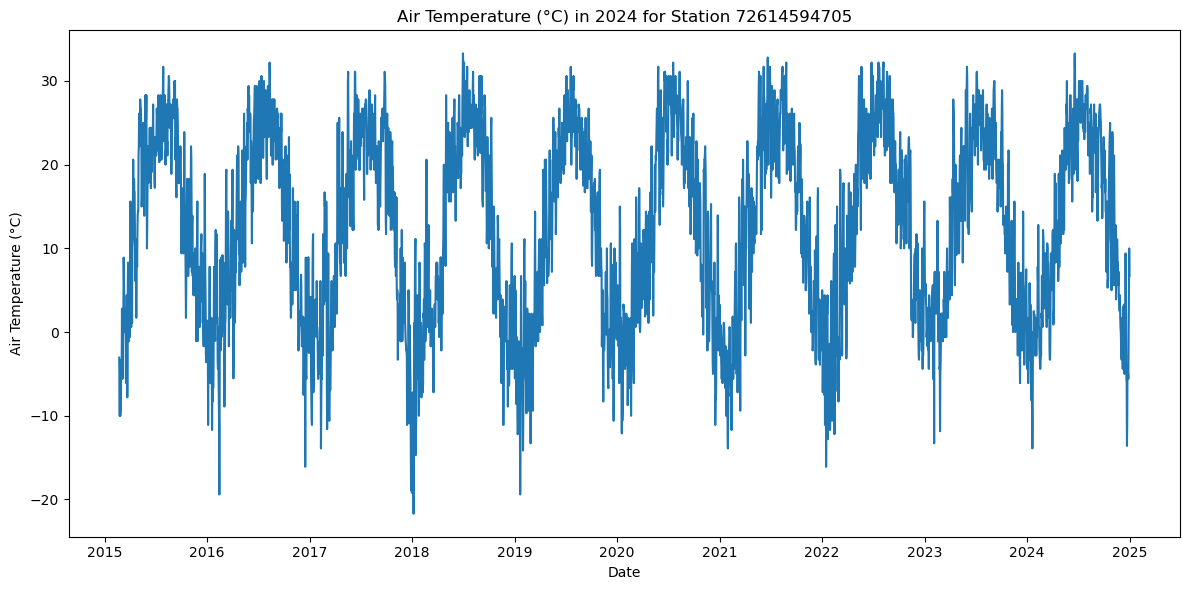

In [15]:
plot_timeseries(
    # df_merged,
    df_lagged,
    xcol="result_date",
    ycol="air_temp_degrees_cels_max",
    xlabel="Date",
    ylabel="Air Temperature (°C)",
    title=f"Air Temperature (°C) in 2024 for Station {stationid}"
)

In [ ]:
plot_timeseries(
    # df_merged,
    df_example,
    xcol="result_date",
    ycol="air_temp_degrees_cels",
    xlabel="Date",
    ylabel="Air Temperature (°C)",
    title=f"Air Temperature (°C) in 2024 for Station {stationid}"
)


plot_timeseries(
    # df_merged,
    df_example,
    xcol="result_date",
    ycol="precip_depth_sum_mm_sum",
    xlabel="Date",
    ylabel="Precipitation (MM)",
    title=f"Precipitation (MM) in 2024 for Station {stationid}"
)


plot_timeseries(
    # df_merged,
    df_example,
    xcol="result_date",
    ycol="Rel_Hum_pct_mean",
    xlabel="Date",
    ylabel="Relative Humidity (PCT)",
    title=f"Relative Humidity (PCT) in 2024 for Station {stationid}"
)


plot_timeseries(
    # df_merged,
    df_example,
    xcol="result_date",
    ycol="Max_RH_pct_max",
    xlabel="Date",
    ylabel="Relative Humidity (Max)",
    title=f"Relative Humidity (Max) in 2024 for Station {stationid}"
)

plot_timeseries(
    # df_merged,
    df_example,
    xcol="result_date",
    ycol="Mean_RH_pct_mean",
    xlabel="Date",
    ylabel="Relative Humidity (PCT)",
    title=f"Relative Humidity (PCT) in 2024 for Station {stationid}"
)

ColumnNotFoundError: "air_temp_degrees_cels" not found

<Figure size 1200x600 with 0 Axes>

In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


try:
    # Prepare data
    df = df_example[["result_date", "air_temp_degrees_cels_median"]].to_pandas()
    df = df.set_index("result_date").sort_index()
    df["air_temp_degrees_cels_median"] = df["air_temp_degrees_cels_median"].interpolate(method="time")

    # Split data: 70% train, 15% val, 15% test
    n = len(df)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)
    train, val, test = df.iloc[:train_end], df.iloc[train_end:val_end], df.iloc[val_end:]

    logging.info(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")

    # Fit ARIMA on train
    model = ARIMA(train["air_temp_degrees_cels_median"], order=(1,0,1))
    model_fit = model.fit()

    # Forecast on validation
    val_forecast = model_fit.forecast(steps=len(val))
    val.index = pd.to_datetime(val.index)
    val_pred = pd.Series(val_forecast, index=val.index)

    # Diagnostics: Plot actual vs predicted for validation
    plt.figure(figsize=(12, 5))
    plt.plot(val.index, val["air_temp_degrees_cels_median"], label="Actual")
    plt.plot(val_pred.index, val_pred, label="Predicted")
    plt.title("Validation: Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Air Temp (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Metrics for validation
    val_rmse = np.sqrt(mean_squared_error(val["air_temp_degrees_cels_median"], val_pred))
    val_mae = mean_absolute_error(val["air_temp_degrees_cels_median"], val_pred)
    logging.info(f"Validation RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}")

    # Refit on train+val, forecast test
    model_full = ARIMA(pd.concat([train, val])["air_temp_degrees_cels_median"], order=(1,0,1))
    model_full_fit = model_full.fit()
    test_forecast = model_full_fit.forecast(steps=len(test))
    test.index = pd.to_datetime(test.index)
    test_pred = pd.Series(test_forecast, index=test.index)

    # Diagnostics: Plot actual vs predicted for test
    plt.figure(figsize=(12, 5))
    plt.plot(test.index, test["air_temp_degrees_cels_median"], label="Actual")
    plt.plot(test_pred.index, test_pred, label="Predicted")
    plt.title("Test: Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Air Temp (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Metrics for test
    test_rmse = np.sqrt(mean_squared_error(test["air_temp_degrees_cels_median"], test_pred))
    test_mae = mean_absolute_error(test["air_temp_degrees_cels_median"], test_pred)
    logging.info(f"Test RMSE: {test_rmse:.3f}, MAE: {test_mae:.3f}")

    # Print metrics table
    metrics_df = pd.DataFrame({
        "RMSE": [val_rmse, test_rmse],
        "MAE": [val_mae, test_mae]
    }, index=["Validation", "Test"])
    print(metrics_df)

except Exception as e:
    logging.error(f"Error in ARIMA time series workflow: {e}")
    raise


2025-08-11 22:40:18,521 - INFO - Train shape: (14, 1), Validation shape: (3, 1), Test shape: (4, 1)


: 